In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
seed=7
np.random.seed(seed)

#Feat extraction

from pydub import AudioSegment
import librosa
import random
import shutil


# Data preperation and splitting

In [ ]:
RAVDESS_path= "/content/drive/MyDrive/EmotionDetectionProject/Datasets/RAVDESS_Trial/AllRAVDESSFiles"


In [ ]:
data_paths=[]
labels=[]
for f in os.listdir(RAVDESS_path):
    fileP = os.path.join(RAVDESS_path,f)
    #print(fileP)
    part = f.split('.')[0].split('-')[2]
    #print(part)

    labels.append(part)
    data_paths.append(fileP)
    #c+=1


In [ ]:
print(len(data_paths))
print(len(labels))

1440
1440


In [ ]:
split_ratio = 0.7  # Split ratio for the first subset

split_index = int(len(data_paths) * split_ratio)
random.shuffle(data_paths)

TrainSet = data_paths[:split_index]
RemSet = data_paths[split_index:]

print(len(TrainSet))
print(len(RemSet))

1007
433


In [ ]:
split_ratio = 0.5  # Split ratio for the first subset

split_index = int(len(RemSet) * split_ratio)
random.shuffle(RemSet)

TestSet = RemSet[:split_index]
ValidSet = RemSet[split_index:]

print(len(TestSet))
print(len(ValidSet))

216
217


# Injecting PN to train set

In [ ]:
# #PNNNNNN
# PN_Train_paths=[]
# PN_Train_labels=[]
# PN_dir= "/content/drive/MyDrive/EmotionDetectionProject/Datasets/RAVDESS_Trial/RAVDESS_PN100%/"

# for fileP in TrainSet:

#   fileN=fileP.split("/")[-1].split(".")[0]
#   #print(fileN)
#   emo=int(fileN.split("-")[2])

#   PNfileN= PN_dir + fileN + "_processed.wav"
#   #print(PNfileN)
#   #print(emo)

#   PN_Train_paths.append(PNfileN)
#   PN_Train_labels.append(emo)




# Non-augmented data Feature Extraction

In [ ]:
TestData_paths=[]
TestData_labels=[]
for f in TestSet:
    fileN=f.split("/")[-1]
    #print(fileN)
    emo = f.split('.')[0].split('-')[2]
    #print(emo)

    TestData_labels.append(emo)
    TestData_paths.append(f)
    #c+=1
print(len(TestData_paths))
print(len(TestData_labels))

216
216


In [ ]:
ValidData_paths=[]
ValidData_labels=[]
for f in ValidSet:
    fileN=f.split("/")[-1]
    #print(fileN)
    emo = f.split('.')[0].split('-')[2]
    #print(emo)

    ValidData_labels.append(emo)
    ValidData_paths.append(f)
    #c+=1
print(len(ValidData_paths))
print(len(ValidData_labels))

217
217


In [ ]:
TrainDataClean_paths=[]
TrainDataClean_labels=[]
for f in TrainSet:
    fileN=f.split("/")[-1]
    #print(f)
    emo = f.split('.')[0].split('-')[2]
    #print(emo)

    TrainDataClean_labels.append(emo)
    TrainDataClean_paths.append(f)
    #c+=1
print(len(TrainDataClean_paths))
print(len(TrainDataClean_labels))

1007
1007


In [ ]:
from itertools import chain, repeat, islice

def pad_infinite(iterable, padding=None):
   return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
   return islice(pad_infinite(iterable, padding), size)

In [ ]:
def extract_all_features(audio_file,n,sampling_rate):
  data=[]
  X, sample_rate = librosa.load(audio_file,sr=sampling_rate, duration=3, offset=0.4)

  mfcc = librosa.feature.mfcc(y=X, sr=sample_rate , n_mfcc=n)
  mfcc=np.mean(mfcc,axis=0)
  mfcc= list(pad(mfcc, 259, 0))
  #print(mfcc)
  #print(len(mfcc))


  spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate , n_mels=128,fmax=8000)
  db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
  log_spectrogram = np.mean(db_spec, axis = 0)
  log_spectrogram= list(pad(log_spectrogram, 259, 0))
  #print(len(log_spectrogram))

  chroma= librosa.feature.chroma_stft(y=X, sr=sample_rate)
  chroma = np.mean(chroma, axis = 0)
  chroma = list(pad(chroma, 259, 0))
  #print(len(chroma))

  zcr = librosa.feature.zero_crossing_rate(y=X)
  zcr = np.mean(zcr, axis= 0)
  zcr =list(pad(zcr, 259, 0))
  #print(len(zcr))

  rmse= librosa.feature.rms(y=X)
  rmse= np.mean(rmse, axis= 0)
  rmse= list(pad(rmse, 259, 0))
  #print(len(rmse))

  data=[mfcc, log_spectrogram, chroma, zcr, rmse]


  return data


In [ ]:
# X_train_clean=[]
# for fileP in TrainDataClean_paths:
#   #print(fileP)
#   l=extract_all_features(fileP,13,44100)
#   X_train_clean.append(l)

In [ ]:
# for i in range(len(TrainDataClean_paths)):
#   print(TrainDataClean_paths[i],TrainDataClean_labels[i])


In [ ]:
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_X_train_clean.npy",X_train_clean)
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_y_train_clean.npy",TrainDataClean_labels)

In [ ]:
# X_test=[]
# for fileP in TestData_paths:
#   #print(fileP)
#   l=extract_all_features(fileP,13,44100)
#   X_test.append(l)

In [ ]:
# for i in range(len(TestData_paths)):
#   print(TestData_paths[i],TestData_labels[i])


In [ ]:
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_X_test.npy",X_test)
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_y_test.npy",TestData_labels)

In [ ]:
# X_valid=[]
# for fileP in ValidData_paths:
#   #print(fileP)
#   l=extract_all_features(fileP,13,44100)
#   X_valid.append(l)

In [ ]:
# for i in range(len(ValidData_paths)):
#   print(ValidData_paths[i],ValidData_labels[i])


In [ ]:
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_X_valid.npy",X_valid)
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_y_valid.npy",ValidData_labels)

# Augmented data Feature Extraction

In [ ]:
# X_train_aug=[]
# for fileN in PN_Train_paths:
#   #fileP= os.path.join(PN_Train_paths,fileN)
#   #print(fileN)
#   l=extract_all_features(fileP,13,44100)
#   X_train_aug.append(l)

KeyboardInterrupt: ignored

In [ ]:
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/PN Injection/TrainSet1007_PN/TrainSet1007_PN_X_train_aug.npy",X_train_aug)
# np.save("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/PN Injection/TrainSet1007_PN/TrainSet1007_PN_y_train_aug.npy",PN_Train_labels)

# Modeling

In [ ]:
X_train_aug= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/PN Injection/TrainSet1007_PN/TrainSet1007_PN_X_train_aug.npy")
y_train_aug= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/PN Injection/TrainSet1007_PN/TrainSet1007_PN_y_train_aug.npy")

In [ ]:
X_train_clean= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_X_train_clean.npy")
y_train_clean= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_y_train_clean.npy")

In [ ]:
X_test= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_X_test.npy")
y_test= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_y_test.npy")

In [ ]:
X_valid= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_X_valid.npy")
y_valid= np.load("/content/drive/MyDrive/EmotionDetectionProject/Code/Feature extraction & pre-processing/Auditory Object Injection/TrainSet1007_AudObj+PN/TrainSet1007_AudObj+PN_y_valid.npy")

In [ ]:

X_train= np.concatenate((X_train_clean,X_train_aug))
print(X_train.shape)

In [ ]:

y_train= np.concatenate((y_train_clean,y_train_aug))
print(y_train.shape)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

In [ ]:
y_train= y_train.astype(int)
y_test= y_test.astype(int)
y_valid= y_valid.astype(int)

In [ ]:
print(np.unique(y_train))
print(np.unique(y_test))
print(np.unique(y_valid))

In [ ]:
y_train.dtype

In [ ]:
X_train=np.reshape(X_train,(2014,259,5))
X_test=np.reshape(X_test,(216,259,5))
X_valid=np.reshape(X_valid,(217,259,5))

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2014, 259, 5)
(216, 259, 5)
(2014,)
(216,)


In [ ]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_valid = (X_valid - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_valid = np.array(X_valid)
y_valid= np.array(y_valid)
# ONE HOT ENCODE THE TARGET
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))#, num_classes=6)
y_test = to_categorical(lb.fit_transform(y_test))#, num_classes=8)
y_valid = to_categorical(lb.fit_transform(y_valid))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR
# X_train = X_train[:,:,:,np.newaxis]
# X_test = X_test[:,:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
(2014, 259, 5)
(216, 259, 5)
(2014, 8)
(216, 8)


(2230, 8)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(259,5)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
#model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=300, validation_data=(X_test, y_test),callbacks=[checkpoint])
model_history=model.fit(X_train,y_train,batch_size=32, epochs=300, validation_data=(X_valid, y_valid),callbacks=[checkpoint])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 259, 256)          10496     
                                                                 
 conv1d_1 (Conv1D)           (None, 252, 256)          524544    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 126, 256)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 126, 256)         1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 126, 256)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 256)          5

Epoch 1/300
63/63 [==============================] - ETA: 0s - loss: 4.8416 - accuracy: 0.1336
Epoch 1: val_accuracy improved from -inf to 0.20737, saving model to SER_best_initial_model.hdf5
63/63 [==============================] - 20s 47ms/step - loss: 4.8416 - accuracy: 0.1336 - val_loss: 4.3243 - val_accuracy: 0.2074
Epoch 2/300
61/63 [============================>.] - ETA: 0s - loss: 4.0809 - accuracy: 0.1460
Epoch 2: val_accuracy did not improve from 0.20737
63/63 [==============================] - 1s 20ms/step - loss: 4.0692 - accuracy: 0.1470 - val_loss: 3.6869 - val_accuracy: 0.1429
Epoch 3/300
61/63 [============================>.] - ETA: 0s - loss: 3.4519 - accuracy: 0.1496
Epoch 3: val_accuracy did not improve from 0.20737
63/63 [==============================] - 1s 20ms/step - loss: 3.4422 - accuracy: 0.1475 - val_loss: 3.1335 - val_accuracy: 0.1935
Epoch 4/300
61/63 [============================>.] - ETA: 0s - loss: 2.9799 - accuracy: 0.1470
Epoch 4: val_accuracy did not 

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=1)
print("test loss, test acc:", results)

216/216 [==============================] - 1s 3ms/step - loss: 2.1048 - accuracy: 0.4954
test loss, test acc: [2.1048498153686523, 0.49537035822868347]


7/7 [==============================] - 0s 50ms/step - loss: 2.1048 - accuracy: 0.4954
Loss of the model is -  2.1048495769500732
7/7 [==============================] - 0s 6ms/step - loss: 2.1048 - accuracy: 0.4954
Accuracy of the model is -  49.53703582286835 %
7/7 [==============================] - 0s 5ms/step


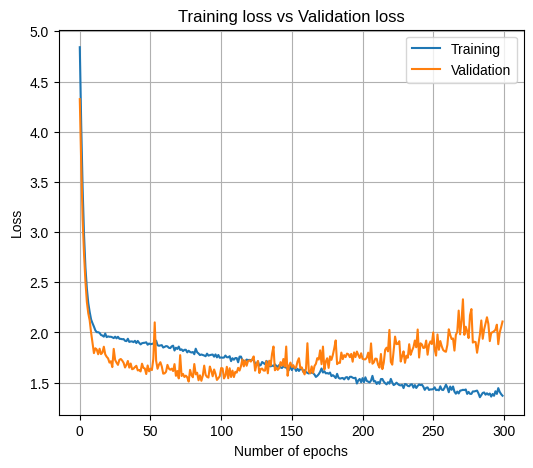

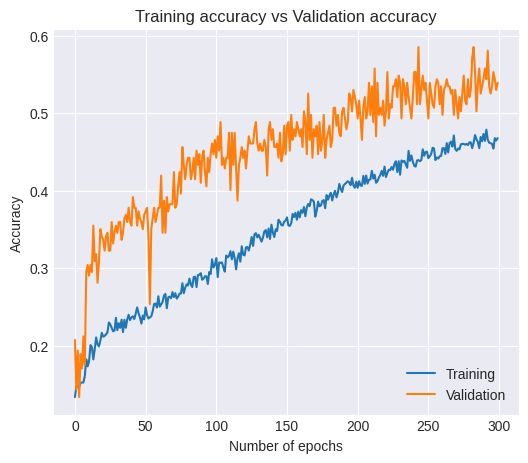

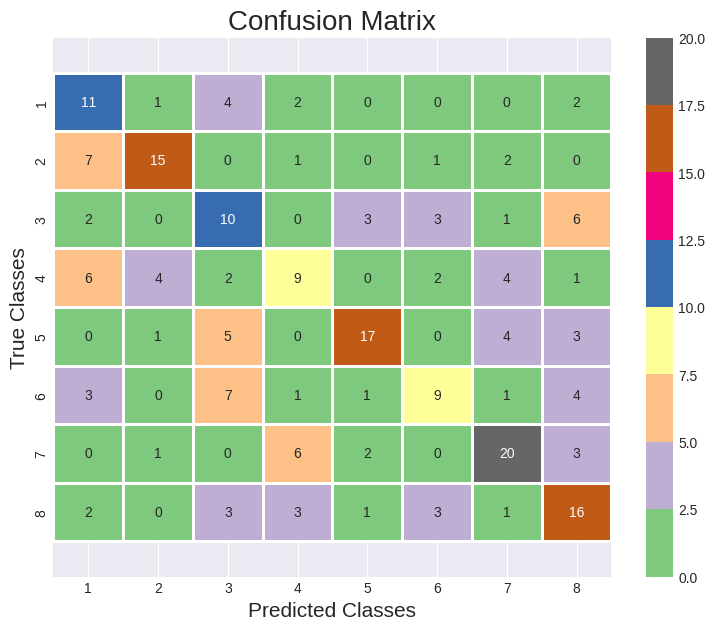

              precision    recall  f1-score   support

       angry       0.35      0.55      0.43        20
     disgust       0.68      0.58      0.62        26
        fear       0.32      0.40      0.36        25
       happy       0.41      0.32      0.36        28
     neutral       0.71      0.57      0.63        30
         sad       0.50      0.35      0.41        26
        calm       0.61      0.62      0.62        32
    surprise       0.46      0.55      0.50        29

    accuracy                           0.50       216
   macro avg       0.50      0.49      0.49       216
weighted avg       0.52      0.50      0.50       216



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50]
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-MFCC.png')
plt.show()

print(classification_report(TRUE, predictions, target_names = ['angry','disgust','fear','happy','neutral','sad','calm','surprise']))

In [ ]:

model.save('/content/drive/MyDrive/EmotionDetectionProject/Models/SER_CNN_mfcc+259_channels_RAVDESS_TrainSet1007_PN_(50).h5',save_format='h5')